# Overvew

- nb035の改良
- 0.5~1.2kHz ---> 0.5~1.6kHzを使う

In [4]:
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

9419fb1


# CONST

In [5]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='3'

In [6]:
NB = '037'
DEBUG = False
PERIOD = 5
# PATH_EVENT = './../data_ignore/event/nb017_event_rms/nb017_event_rms.csv'
DATASET = '32khz'
DIR_MODEL = './../data_ignore/model'
PATH_MODEL = './../data_ignore/model/resnest50/resnest50_fast_1s1x64d-d8fbf808.pth'

In [7]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 70
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 500
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 20
    shuffle: True
    num_workers: 2
    pin_memory: True
    drop_last: True
  val:
    batch_size: 10
    shuffle: False
    num_workers: 2
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [8]:
import os
import gc
import typing as tp
import logging
import cv2 
import warnings
import math
import time
import yaml
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from contextlib import contextmanager
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
# from torchvision import models
import torch.nn.functional as F
import torch.utils.data as data
import resnest.torch as resnest_torch
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
from torch.nn.modules.utils import _pair

import sys
sys.path.insert(0, './../src/util/')
from const import BIRD_CODE, INV_BIRD_CODE

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# My function

In [9]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    

In [10]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [11]:
class SpectrogramDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
#         sr, y = wavfile.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

class SpectrogramEventRmsDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
        self.df_rms = pd.read_csv(PATH_FEAT)
        self.sr_feat = 4

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
        
        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                basename = os.path.basename(wav_path)
                rms = self.df_rms.query('filename == @basename').librosa_rms.values
                x_feat_sec = np.arange(0, len(rms))/self.sr_feat + 1/self.sr_feat
                event_mask = rms > 1.3*np.median(rms)
                
                silent = ~any(event_mask)
                if silent:
                    # event を検出できなかったらランダムにクロップ
                    start = np.random.randint(len_y - effective_length)
                    y = y[start:start + effective_length].astype(np.float32)
                else:
                    choice = random.choice(x_feat_sec[event_mask])
                    ed_sec = x_feat_sec[-1]
                    st_range_sec = 2.5001
                    ed_range_sec = ed_sec - 2.5001
                    range_in = (st_range_sec <= choice) & (choice <= ed_range_sec)
                    if range_in:
                        idxs = np.arange(len_y)
                        x_sec = idxs/sr
                        mask = (choice - 2.5) < x_sec
                        start = idxs[mask][0]
                        y = y[start:start + effective_length].astype(np.float32)
                    else:
                        # ランダムにクロップ
                        start = np.random.randint(len_y - effective_length)
                        y = y[start:start + effective_length].astype(np.float32)
                    
                # ----
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

In [12]:
class SpectrogramEventRmsDatasetV3(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
#         self.df_rms = pd.read_csv(PATH_FEAT)
        self.df_event = pd.read_csv(PATH_EVENT)
        self.sr_feat = 4

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
        
        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                basename = os.path.basename(wav_path)
                event_sec_list = self.df_event.query('filename == @basename').event_sec_list.to_list()[0]
                event_sec_list = self.string_to_list(event_sec_list)
                
                # on event
                if len(event_sec_list) != 0:
                    choice = random.choice(event_sec_list)
                    # 前から2.5秒、後ろから2.5秒の範囲におさまってるか(境界問題)
                    ed_sec = len_y / sr
                    st_range_sec = PERIOD/2 + 0.0001
                    ed_range_sec = ed_sec - st_range_sec
                    range_in = (st_range_sec <= choice) & (choice <= ed_range_sec)
                    if range_in:
                        start = int((choice - PERIOD/2) * sr)
                        y = y[start:start + effective_length].astype(np.float32)
                    else:
                        # ランダムにクロップ
                        start = np.random.randint(len_y - effective_length)
                        y = y[start:start + effective_length].astype(np.float32)
                # off event
                else:
                    # event を検出できなかったらランダムにクロップ
                    start = np.random.randint(len_y - effective_length)
                    y = y[start:start + effective_length].astype(np.float32)
                    
                # ----
            else:
                y = y.astype(np.float32)


        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels
    
    def string_to_list(self, list_str):
        for str_replace in ['\n', '[', ']']:
            list_str = list_str.replace(str_replace, '')

        split = list_str.split(' ')
        events_num = []
        for text in split:
            try:
                num = np.float32(text)
                events_num.append(num)
            except:
                pass
        return events_num

In [13]:
def get_loaders_for_training(dataset_class, args_dataset, args_loader, train_file_list, valid_file_list):
    # # make dataset
    train_dataset = dataset_class(train_file_list, **args_dataset)
    val_dataset = dataset_class(valid_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    valid_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, valid_loader

In [14]:
class SplAtConv2d(Module):
    """Split-Attention Conv2d
    """
    def __init__(self, in_channels, channels, kernel_size, stride=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, bias=True,
                 radix=2, reduction_factor=4,
                 rectify=False, rectify_avg=False, norm_layer=None,
                 dropblock_prob=0.0, **kwargs):
        super(SplAtConv2d, self).__init__()
        padding = _pair(padding)
        self.rectify = rectify and (padding[0] > 0 or padding[1] > 0)
        self.rectify_avg = rectify_avg
        inter_channels = max(in_channels*radix//reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels
        self.dropblock_prob = dropblock_prob
        if self.rectify:
            from rfconv import RFConv2d
            self.conv = RFConv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                                 groups=groups*radix, bias=bias, average_mode=rectify_avg, **kwargs)
        else:
            self.conv = Conv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                               groups=groups*radix, bias=bias, **kwargs)
        self.use_bn = norm_layer is not None
        if self.use_bn:
            self.bn0 = norm_layer(channels*radix)
        self.relu = ReLU(inplace=True)
        self.fc1 = Conv2d(channels, inter_channels, 1, groups=self.cardinality)
        if self.use_bn:
            self.bn1 = norm_layer(inter_channels)
        self.fc2 = Conv2d(inter_channels, channels*radix, 1, groups=self.cardinality)
        if dropblock_prob > 0.0:
            self.dropblock = DropBlock2D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            if torch.__version__ < '1.5':
                splited = torch.split(x, int(rchannel//self.radix), dim=1)
            else:
                splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited) 
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        if self.use_bn:
            gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            if torch.__version__ < '1.5':
                attens = torch.split(atten, int(rchannel//self.radix), dim=1)
            else:
                attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x
class DropBlock2D(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return nn.functional.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(Bottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv2d(
            group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """ResNet Variants
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, radix=1, groups=1, bottleneck_width=64,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 rectified_conv=False, rectify_avg=False,
                 avd=False, avd_first=False,
                 final_drop=0.0, dropblock_prob=0,
                 last_gamma=False, norm_layer=nn.BatchNorm2d):
        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first

        super(ResNet, self).__init__()
        self.rectified_conv = rectified_conv
        self.rectify_avg = rectify_avg
        if rectified_conv:
            from rfconv import RFConv2d
            conv_layer = RFConv2d
        else:
            conv_layer = nn.Conv2d
        conv_kwargs = {'average_mode': rectify_avg} if rectified_conv else {}
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False, **conv_kwargs)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        self.avgpool = GlobalAvgPool2d()
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    dropblock_prob=0.0, is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=1, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=2, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=dilation, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x
    
class DropBlock2D(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return nn.functional.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(Bottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv2d(
            group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """ResNet Variants
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, radix=1, groups=1, bottleneck_width=64,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 rectified_conv=False, rectify_avg=False,
                 avd=False, avd_first=False,
                 final_drop=0.0, dropblock_prob=0,
                 last_gamma=False, norm_layer=nn.BatchNorm2d):
        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first

        super(ResNet, self).__init__()
        self.rectified_conv = rectified_conv
        self.rectify_avg = rectify_avg
        if rectified_conv:
            from rfconv import RFConv2d
            conv_layer = RFConv2d
        else:
            conv_layer = nn.Conv2d
        conv_kwargs = {'average_mode': rectify_avg} if rectified_conv else {}
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False, **conv_kwargs)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        self.avgpool = GlobalAvgPool2d()
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    dropblock_prob=0.0, is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=1, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=2, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=dilation, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x

In [15]:
def get_model(args: tp.Dict):
    # # get resnest50_fast_1s1x64d
    model = ResNet(
        Bottleneck, [3, 4, 6, 3],
        radix=1, groups=1, bottleneck_width=64,
        deep_stem=True, stem_width=32, avg_down=True,
        avd=True, avd_first=True)
    
    state_dict = torch.load(args["trained_weights"])
    model.load_state_dict(state_dict)
    
    del model.fc
    # # use the same head as the baseline notebook.
    model.fc = nn.Sequential(
        nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, args["num_classes"]))
    
#     state_dict = torch.load(args["trained_weights"])
#     model.load_state_dict(state_dict)
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    
    return model

# def get_model(args: tp.Dict):
#     model =getattr(resnest_torch, args["name"])(pretrained=args["params"]["pretrained"])
#     del model.fc
#     # # use the same head as the baseline notebook.
#     model.fc = nn.Sequential(
#         nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
#         nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
#         nn.Linear(1024, args["params"]["n_classes"]))
    
#     return model

# Preparation

settings

In [16]:
pd.set_option('display.max_columns', 100)

In [17]:
settings = yaml.safe_load(settings_str)
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

for k, v in settings.items():
    print("[{}]".format(k))
    print(v)
set_seed(settings["globals"]["seed"])

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 70, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 500, 'fmax': 16000}}}
[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}
[loader]
{'train': {'batch_size': 20, 'shuffle': True, 'num_workers': 2, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 10, 'shuffle': False, 'num_workers': 2, 'pin_memory': True, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}
[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}
[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}
[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}


<br>

data path

In [18]:
root = Path.cwd().parent
input_ex_root = root / 'data_ignore/external_dataset' / DATASET
train_resampled_audio_dirs = [input_ex_root / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [19]:
train_resampled_audio_dirs

[PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-01'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-02'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-03'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-04')]

<br>

load data

In [20]:
train = pd.read_csv(train_resampled_audio_dirs[0] / "train_mod.csv")

# Execution

<br>

train_all を作成  
train_all: リサンプル後のファイルパスなどを追加

In [21]:
tmp_list = []
for audio_d in train_resampled_audio_dirs:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for i, wav_f in enumerate(ebird_d.iterdir()):
            bool_n_splits = i==settings['split']['params']['n_splits']
            if bool_n_splits and DEBUG: break  # if DEBUG=True: 1bird/n_splits file
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

if DEBUG: print('----- debug mode -----')
print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


<br>

fold

In [22]:
skf = StratifiedKFold(**settings["split"]["params"])

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id

In [23]:
fold_proportion = pd.pivot_table(train_all, index="ebird_code", columns="fold", values="xc_id", aggfunc=len)
print(fold_proportion.shape)
fold_proportion

(264, 5)


fold,0,1,2,3,4
ebird_code,,,,,
aldfly,20,20,20,20,20
ameavo,8,8,8,7,7
amebit,9,9,8,9,9
amecro,20,20,20,20,20
amegfi,20,20,20,20,20
...,...,...,...,...,...
yebsap,13,12,12,13,13
yehbla,11,12,12,11,11
yelwar,18,18,17,18,18


In [24]:
use_fold = settings["globals"]["use_fold"]
idx_train = train_all['fold']!=use_fold
idx_valid = train_all['fold']==use_fold
train_file_list = train_all[idx_train][['file_path', 'ebird_code']].values.tolist()
valid_file_list = train_all[idx_valid][['file_path', 'ebird_code']].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(valid_file_list)))

[fold 0] train: 17100, val: 4275


In [25]:
len(train_file_list)+len(valid_file_list)

21375

In [26]:
device = torch.device(settings['globals']['device'])

<br>

**<font color='orange'> -------------------- settings ------------------ </font>**

In [27]:
# # # get loader
train_loader, valid_loader = get_loaders_for_training(
    SpectrogramDataset,
    settings["dataset"]["params"], settings["loader"], train_file_list, valid_file_list)

In [28]:
# resnet18
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(in_features=512, out_features=len(BIRD_CODE))

# resnet34
# model = models.resnet34(pretrained=True)
# model.fc = nn.Linear(in_features=512, out_features=len(BIRD_CODE))

# resnet50 のファインチューニング
# model = models.resnet50(pretrained=True)
# model.fc = nn.Linear(in_features=2048, out_features=len(BIRD_CODE))

# resnest
model = getattr(resnest_torch, settings['model']["name"])(pretrained=settings['model']["params"]["pretrained"])
del model.fc
model.fc = nn.Sequential(
    nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
    nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
    nn.Linear(1024, settings['model']["params"]["n_classes"]))

# resnest
# model_config = {
#     "base_model_name": "resnest50_fast_1s1x64d",
#     "pretrained": False,
#     "num_classes": 264,
#     "trained_weights": PATH_MODEL,
# }
# model = get_model(model_config)


model = model.to(device)
print(f'model name: {model.__class__.__name__}')

model name: ResNet


**<font color='orange'> ------------------------------------------------ </font>**

In [29]:
# # # get optimizer
optimizer = getattr(
        torch.optim, settings["optimizer"]["name"]
        )(model.parameters(), **settings["optimizer"]["params"])

# # # get scheduler
scheduler = getattr(
    torch.optim.lr_scheduler, settings["scheduler"]["name"]
    )(optimizer, **settings["scheduler"]["params"])

# # # get loss
loss_func = getattr(nn, settings["loss"]["name"])(**settings["loss"]["params"])

In [30]:
def train(model, device, train_loader, optimizer, scheduler, loss_func):
    model.train()
    epoch_train_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()*data.size(0)
    scheduler.step()
    loss = epoch_train_loss / len(train_loader.dataset)
    del data
    return loss

class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
#         self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
#         self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss
        
def get_epoch_loss_score(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    y_pred_list = []
    y_true_list = []
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
        
#         out_numpy = output.detach().cpu().numpy()
        _y_pred = output.detach().cpu().numpy().argmax(axis=1)
        y_pred_list.append(_y_pred)
        _y_true = target.detach().cpu().numpy().argmax(axis=1)
        y_true_list.append(_y_true)
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    y_pred = np.concatenate(y_pred_list, axis=0)
    y_true = np.concatenate(y_true_list, axis=0)
    f_score = f1_score(y_true, y_pred, average='macro')
    del data
    return loss, f_score

def evaluate(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

In [31]:
save_dir = f'{DIR_MODEL}/nb{NB}_{model.__class__.__name__}/'
file_dir = os.path.dirname(save_dir)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)
save_path = f'{save_dir}model_{model.__class__.__name__}.pth'
print(save_path)

./../data_ignore/model/nb037_ResNet/model_ResNet.pth


In [32]:
losses_train = []
losses_valid = []
epochs = []

early_stopping = EarlyStopping(patience=20, verbose=True, path=save_path)
n_epoch = settings['globals']['num_epochs']
# n_epoch = 50
for epoch in progress_bar(range(1, n_epoch+1)):
    print(f'\n epoch: {epoch} {time.ctime()}')
    loss_train = train(model, device, train_loader, optimizer, scheduler, loss_func)
    loss_valid, f_score_valid = get_epoch_loss_score(model, device, valid_loader, loss_func)
    print(f'loss_train: {loss_train:.6f}, loss_valid: {loss_valid:.6f}, f1(macro): {f_score_valid:.6f}')
    
    epochs.append(epoch)
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)
    
    early_stopping(loss_valid, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
# model.load_state_dict(early_stopping.best_state_dict)


 epoch: 1 Thu Aug 27 21:10:04 2020


loss_train: 0.027800, loss_valid: 0.024631, f1(macro): 0.001264
Validation loss decreased (inf --> 0.024631).  Saving model ...

 epoch: 2 Thu Aug 27 21:24:20 2020


loss_train: 0.023165, loss_valid: 0.021604, f1(macro): 0.019471
Validation loss decreased (0.024631 --> 0.021604).  Saving model ...

 epoch: 3 Thu Aug 27 21:38:39 2020


loss_train: 0.020926, loss_valid: 0.019974, f1(macro): 0.057828
Validation loss decreased (0.021604 --> 0.019974).  Saving model ...

 epoch: 4 Thu Aug 27 21:52:50 2020


loss_train: 0.019003, loss_valid: 0.018147, f1(macro): 0.130877
Validation loss decreased (0.019974 --> 0.018147).  Saving model ...

 epoch: 5 Thu Aug 27 22:07:09 2020


loss_train: 0.017355, loss_valid: 0.016611, f1(macro): 0.190253
Validation loss decreased (0.018147 --> 0.016611).  Saving model ...

 epoch: 6 Thu Aug 27 22:21:30 2020


loss_train: 0.015939, loss_valid: 0.015617, f1(macro): 0.245903
Validation loss decreased (0.016611 --> 0.015617).  Saving model ...

 epoch: 7 Thu Aug 27 22:35:48 2020


loss_train: 0.014474, loss_valid: 0.014272, f1(macro): 0.325909
Validation loss decreased (0.015617 --> 0.014272).  Saving model ...

 epoch: 8 Thu Aug 27 22:50:00 2020


loss_train: 0.013177, loss_valid: 0.013373, f1(macro): 0.375916
Validation loss decreased (0.014272 --> 0.013373).  Saving model ...

 epoch: 9 Thu Aug 27 23:04:13 2020


loss_train: 0.012204, loss_valid: 0.012651, f1(macro): 0.409482
Validation loss decreased (0.013373 --> 0.012651).  Saving model ...

 epoch: 10 Thu Aug 27 23:18:37 2020


loss_train: 0.011461, loss_valid: 0.012227, f1(macro): 0.439406
Validation loss decreased (0.012651 --> 0.012227).  Saving model ...

 epoch: 11 Thu Aug 27 23:32:50 2020


loss_train: 0.011284, loss_valid: 0.012238, f1(macro): 0.437356
EarlyStopping counter: 1 out of 20

 epoch: 12 Thu Aug 27 23:47:03 2020


loss_train: 0.011272, loss_valid: 0.012156, f1(macro): 0.441232
Validation loss decreased (0.012227 --> 0.012156).  Saving model ...

 epoch: 13 Fri Aug 28 00:01:25 2020


loss_train: 0.011425, loss_valid: 0.012264, f1(macro): 0.439256
EarlyStopping counter: 1 out of 20

 epoch: 14 Fri Aug 28 00:15:40 2020


loss_train: 0.011620, loss_valid: 0.012326, f1(macro): 0.445590
EarlyStopping counter: 2 out of 20

 epoch: 15 Fri Aug 28 00:29:58 2020


loss_train: 0.011945, loss_valid: 0.012636, f1(macro): 0.420139
EarlyStopping counter: 3 out of 20

 epoch: 16 Fri Aug 28 00:44:12 2020


loss_train: 0.012047, loss_valid: 0.012851, f1(macro): 0.417381
EarlyStopping counter: 4 out of 20

 epoch: 17 Fri Aug 28 00:58:29 2020


loss_train: 0.012167, loss_valid: 0.012722, f1(macro): 0.409751
EarlyStopping counter: 5 out of 20

 epoch: 18 Fri Aug 28 01:12:43 2020


loss_train: 0.012074, loss_valid: 0.012805, f1(macro): 0.437307
EarlyStopping counter: 6 out of 20

 epoch: 19 Fri Aug 28 01:27:02 2020


loss_train: 0.011674, loss_valid: 0.012868, f1(macro): 0.423128
EarlyStopping counter: 7 out of 20

 epoch: 20 Fri Aug 28 01:41:20 2020


loss_train: 0.011426, loss_valid: 0.013097, f1(macro): 0.415167
EarlyStopping counter: 8 out of 20

 epoch: 21 Fri Aug 28 01:55:43 2020


loss_train: 0.010906, loss_valid: 0.011677, f1(macro): 0.491509
Validation loss decreased (0.012156 --> 0.011677).  Saving model ...

 epoch: 22 Fri Aug 28 02:10:03 2020


loss_train: 0.010216, loss_valid: 0.012432, f1(macro): 0.468589
EarlyStopping counter: 1 out of 20

 epoch: 23 Fri Aug 28 02:24:24 2020


loss_train: 0.009651, loss_valid: 0.011572, f1(macro): 0.495879
Validation loss decreased (0.011677 --> 0.011572).  Saving model ...

 epoch: 24 Fri Aug 28 02:38:42 2020


loss_train: 0.008834, loss_valid: 0.011315, f1(macro): 0.520276
Validation loss decreased (0.011572 --> 0.011315).  Saving model ...

 epoch: 25 Fri Aug 28 02:53:00 2020


loss_train: 0.008073, loss_valid: 0.010440, f1(macro): 0.565101
Validation loss decreased (0.011315 --> 0.010440).  Saving model ...

 epoch: 26 Fri Aug 28 03:07:17 2020


loss_train: 0.007338, loss_valid: 0.010074, f1(macro): 0.586589
Validation loss decreased (0.010440 --> 0.010074).  Saving model ...

 epoch: 27 Fri Aug 28 03:21:43 2020


loss_train: 0.006663, loss_valid: 0.009685, f1(macro): 0.610943
Validation loss decreased (0.010074 --> 0.009685).  Saving model ...

 epoch: 28 Fri Aug 28 03:36:04 2020


loss_train: 0.006091, loss_valid: 0.009577, f1(macro): 0.624521
Validation loss decreased (0.009685 --> 0.009577).  Saving model ...

 epoch: 29 Fri Aug 28 03:50:19 2020


loss_train: 0.005550, loss_valid: 0.009382, f1(macro): 0.631107
Validation loss decreased (0.009577 --> 0.009382).  Saving model ...

 epoch: 30 Fri Aug 28 04:04:41 2020


loss_train: 0.005313, loss_valid: 0.009328, f1(macro): 0.632743
Validation loss decreased (0.009382 --> 0.009328).  Saving model ...

 epoch: 31 Fri Aug 28 04:18:56 2020


loss_train: 0.005374, loss_valid: 0.009334, f1(macro): 0.630606
EarlyStopping counter: 1 out of 20

 epoch: 32 Fri Aug 28 04:33:17 2020


loss_train: 0.005310, loss_valid: 0.009318, f1(macro): 0.636740
Validation loss decreased (0.009328 --> 0.009318).  Saving model ...

 epoch: 33 Fri Aug 28 04:47:35 2020


loss_train: 0.005308, loss_valid: 0.009369, f1(macro): 0.629920
EarlyStopping counter: 1 out of 20

 epoch: 34 Fri Aug 28 05:01:57 2020


loss_train: 0.005476, loss_valid: 0.009619, f1(macro): 0.629891
EarlyStopping counter: 2 out of 20

 epoch: 35 Fri Aug 28 05:16:21 2020


loss_train: 0.005728, loss_valid: 0.009945, f1(macro): 0.624238
EarlyStopping counter: 3 out of 20

 epoch: 36 Fri Aug 28 05:30:40 2020


loss_train: 0.006134, loss_valid: 0.010008, f1(macro): 0.611476
EarlyStopping counter: 4 out of 20

 epoch: 37 Fri Aug 28 05:44:59 2020


loss_train: 0.006378, loss_valid: 0.010267, f1(macro): 0.601338
EarlyStopping counter: 5 out of 20

 epoch: 38 Fri Aug 28 05:59:16 2020


loss_train: 0.006887, loss_valid: 0.010478, f1(macro): 0.585508
EarlyStopping counter: 6 out of 20

 epoch: 39 Fri Aug 28 06:13:42 2020


loss_train: 0.007049, loss_valid: 0.011026, f1(macro): 0.554067
EarlyStopping counter: 7 out of 20

 epoch: 40 Fri Aug 28 06:28:00 2020


loss_train: 0.007076, loss_valid: 0.011040, f1(macro): 0.575537
EarlyStopping counter: 8 out of 20

 epoch: 41 Fri Aug 28 06:42:19 2020


loss_train: 0.006875, loss_valid: 0.011133, f1(macro): 0.547519
EarlyStopping counter: 9 out of 20

 epoch: 42 Fri Aug 28 06:56:37 2020


loss_train: 0.006748, loss_valid: 0.010603, f1(macro): 0.584007
EarlyStopping counter: 10 out of 20

 epoch: 43 Fri Aug 28 07:10:57 2020


loss_train: 0.006353, loss_valid: 0.010395, f1(macro): 0.599261
EarlyStopping counter: 11 out of 20

 epoch: 44 Fri Aug 28 07:25:17 2020


loss_train: 0.005816, loss_valid: 0.010240, f1(macro): 0.609909
EarlyStopping counter: 12 out of 20

 epoch: 45 Fri Aug 28 07:39:46 2020


loss_train: 0.005353, loss_valid: 0.009944, f1(macro): 0.620050
EarlyStopping counter: 13 out of 20

 epoch: 46 Fri Aug 28 07:54:07 2020


loss_train: 0.004812, loss_valid: 0.009812, f1(macro): 0.632955
EarlyStopping counter: 14 out of 20

 epoch: 47 Fri Aug 28 08:08:26 2020


loss_train: 0.004336, loss_valid: 0.009924, f1(macro): 0.626010
EarlyStopping counter: 15 out of 20

 epoch: 48 Fri Aug 28 08:22:45 2020


loss_train: 0.004025, loss_valid: 0.009582, f1(macro): 0.647168
EarlyStopping counter: 16 out of 20

 epoch: 49 Fri Aug 28 08:37:04 2020


loss_train: 0.003705, loss_valid: 0.009504, f1(macro): 0.658927
EarlyStopping counter: 17 out of 20

 epoch: 50 Fri Aug 28 08:51:26 2020


loss_train: 0.003576, loss_valid: 0.009463, f1(macro): 0.661769
EarlyStopping counter: 18 out of 20

 epoch: 51 Fri Aug 28 09:05:47 2020


loss_train: 0.003478, loss_valid: 0.009429, f1(macro): 0.663514
EarlyStopping counter: 19 out of 20

 epoch: 52 Fri Aug 28 09:20:02 2020


loss_train: 0.003507, loss_valid: 0.009458, f1(macro): 0.663699
EarlyStopping counter: 20 out of 20
Early stopping


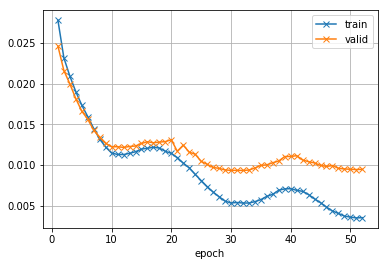

In [33]:
plt.plot(epochs, losses_train, '-x', label='train')
plt.plot(epochs, losses_valid, '-x', label='valid')
plt.xlabel('epoch')
plt.grid()
plt.legend()

In [34]:
del train_loader
# del valid_loader
# del model
del optimizer
del scheduler
# del loss_func

gc.collect()

0

# Predection check

In [38]:
if DEBUG:
    pass
else:
    load_weights = torch.load(save_path)
    model.load_state_dict(load_weights)

In [39]:
loss_valid, f_score_valid = get_epoch_loss_score(model, device, valid_loader, loss_func)
loss_valid

0.009457506912793455

In [40]:
class TestDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, clip: np.ndarray,
                 img_size=224, melspectrogram_parameters={}):
        self.df = df
        self.clip = clip
        self.img_size = img_size
        self.melspectrogram_parameters = melspectrogram_parameters
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        SR = 32000
        sample = self.df.loc[idx, :]
        site = sample.site
        row_id = sample.row_id
        
        if site == "site_3":
            y = self.clip.astype(np.float32)
            len_y = len(y)
            start = 0
            end = SR * 5
            images = []
            while len_y > start:
                y_batch = y[start:end].astype(np.float32)
                if len(y_batch) != (SR * 5):
                    break
                start = end
                end = end + SR * 5
                
                melspec = librosa.feature.melspectrogram(y_batch,
                                                         sr=SR,
                                                         **self.melspectrogram_parameters)
                melspec = librosa.power_to_db(melspec).astype(np.float32)
                image = mono_to_color(melspec)
                height, width, _ = image.shape
                image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
                image = np.moveaxis(image, 2, 0)
                image = (image / 255.0).astype(np.float32)
                images.append(image)
            images = np.asarray(images)
            return images, row_id, site
        else:
            end_seconds = int(sample.seconds)
            start_seconds = int(end_seconds - 5)
            
            start_index = SR * start_seconds
            end_index = SR * end_seconds
            
            y = self.clip[start_index:end_index].astype(np.float32)

            melspec = librosa.feature.melspectrogram(y, sr=SR, **self.melspectrogram_parameters)
            melspec = librosa.power_to_db(melspec).astype(np.float32)

            image = mono_to_color(melspec)
            height, width, _ = image.shape
            image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
            image = np.moveaxis(image, 2, 0)
            image = (image / 255.0).astype(np.float32)

            return image, row_id, site
        
def prediction_for_clip(test_df: pd.DataFrame, 
                        clip: np.ndarray, 
                        model, 
                        mel_params: dict, 
                        threshold=0.5):

    dataset = TestDataset(df=test_df, 
                          clip=clip,
                          img_size=224,
                          melspectrogram_parameters=mel_params)
    loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    prediction_dict = {}
    for image, row_id, site in progress_bar(loader):
        site = site[0]
        row_id = row_id[0]
        if site in {"site_1", "site_2"}:
            image = image.to(device)

            with torch.no_grad():
                prediction = model(image)
                proba = F.sigmoid(prediction).detach().cpu().numpy().reshape(-1)

            events = proba >= threshold
            labels = np.argwhere(events).reshape(-1).tolist()
            

        else:
            # to avoid prediction on large batch
            image = image.squeeze(0)
            batch_size = 16
            whole_size = image.size(0)
            if whole_size % batch_size == 0:
                n_iter = whole_size // batch_size
            else:
                n_iter = whole_size // batch_size + 1
                
            all_events = set()
            for batch_i in range(n_iter):
                batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
#                 if batch.ndim == 3:
#                     batch = batch.unsqueeze(0)

                batch = batch.to(device)
                with torch.no_grad():
                    prediction = model(batch)
                    proba = F.sigmoid(prediction).detach().cpu().numpy()              
                events = proba >= threshold
                for i in range(len(events)):
                    event = events[i, :]
                    labels = np.argwhere(event).reshape(-1).tolist()
                    for label in labels:
                        all_events.add(label)
                        
            labels = list(all_events)
        if len(labels) == 0:
            prediction_dict[row_id] = "nocall"
        else:
            labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
            label_string = " ".join(labels_str_list)
            prediction_dict[row_id] = label_string
    return prediction_dict

def prediction(test_df: pd.DataFrame,
               test_audio: Path,
               mel_params: dict,
               model,
               threshold=0.5):
    
    unique_audio_id = test_df.audio_id.unique()

    warnings.filterwarnings("ignore")
    prediction_dfs = []
    for audio_id in unique_audio_id:
        with timer(f"Loading {audio_id}", logger):
            clip, _ = librosa.load(f'{test_audio}/{audio_id}.mp3',
                                   sr=TARGET_SR,
                                   mono=True,
                                   res_type="kaiser_fast")
        
        test_df_for_audio_id = test_df.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        with timer(f"Prediction on {audio_id}", logger):
            prediction_dict = prediction_for_clip(test_df_for_audio_id,
                                                  clip=clip,
                                                  model=model,
                                                  mel_params=mel_params,
                                                  threshold=threshold)
        row_id = list(prediction_dict.keys())
        birds = list(prediction_dict.values())
        prediction_df = pd.DataFrame({
            "row_id": row_id,
            "birds": birds
        })
        prediction_dfs.append(prediction_df)
    
    prediction_df = pd.concat(prediction_dfs, axis=0, sort=False).reset_index(drop=True)
    return prediction_df

@contextmanager
def timer(name: str, logger):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
        
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger

In [41]:
# logger = get_logger("main.log")
logger = get_logger()
set_seed(1213)

dir_test_audio = '../data/external_dataset/birdcall-check/test_audio/'
test = pd.read_csv('./../data/external_dataset/birdcall-check/test.csv')
sub = pd.read_csv('./../data_ignore/official/sample_submission.csv')

2020-08-28 09:36:54,024 - INFO - logger set up


In [42]:
# melspectrogram_parameters = {
#     "n_mels": 128,
#     "fmin": 20,
#     "fmax": 16000
# }

THRESHOLD = 0.6
TARGET_SR = 32000

In [43]:
submission = prediction(test_df=test,
                        test_audio=dir_test_audio,
                        model=model,
                        mel_params=settings['dataset']['params']['melspectrogram_parameters'],
                        threshold=THRESHOLD)

2020-08-28 09:36:54,054 - INFO - [Loading 41e6fe6504a34bf6846938ba78d13df1] start
2020-08-28 09:36:55,444 - INFO - [Loading 41e6fe6504a34bf6846938ba78d13df1] done in 1.39 s
2020-08-28 09:36:55,451 - INFO - [Prediction on 41e6fe6504a34bf6846938ba78d13df1] start


2020-08-28 09:36:55,765 - INFO - [Prediction on 41e6fe6504a34bf6846938ba78d13df1] done in 0.31 s
2020-08-28 09:36:55,767 - INFO - [Loading cce64fffafed40f2b2f3d3413ec1c4c2] start
2020-08-28 09:36:56,280 - INFO - [Loading cce64fffafed40f2b2f3d3413ec1c4c2] done in 0.51 s
2020-08-28 09:36:56,284 - INFO - [Prediction on cce64fffafed40f2b2f3d3413ec1c4c2] start


2020-08-28 09:36:56,773 - INFO - [Prediction on cce64fffafed40f2b2f3d3413ec1c4c2] done in 0.49 s
2020-08-28 09:36:56,775 - INFO - [Loading 99af324c881246949408c0b1ae54271f] start
2020-08-28 09:36:57,310 - INFO - [Loading 99af324c881246949408c0b1ae54271f] done in 0.53 s
2020-08-28 09:36:57,314 - INFO - [Prediction on 99af324c881246949408c0b1ae54271f] start


2020-08-28 09:36:57,767 - INFO - [Prediction on 99af324c881246949408c0b1ae54271f] done in 0.45 s
2020-08-28 09:36:57,769 - INFO - [Loading 6ab74e177aa149468a39ca10beed6222] start
2020-08-28 09:36:58,257 - INFO - [Loading 6ab74e177aa149468a39ca10beed6222] done in 0.49 s
2020-08-28 09:36:58,260 - INFO - [Prediction on 6ab74e177aa149468a39ca10beed6222] start


2020-08-28 09:36:58,711 - INFO - [Prediction on 6ab74e177aa149468a39ca10beed6222] done in 0.45 s
2020-08-28 09:36:58,713 - INFO - [Loading b2fd3f01e9284293a1e33f9c811a2ed6] start
2020-08-28 09:36:59,229 - INFO - [Loading b2fd3f01e9284293a1e33f9c811a2ed6] done in 0.52 s
2020-08-28 09:36:59,232 - INFO - [Prediction on b2fd3f01e9284293a1e33f9c811a2ed6] start


2020-08-28 09:36:59,767 - INFO - [Prediction on b2fd3f01e9284293a1e33f9c811a2ed6] done in 0.54 s
2020-08-28 09:36:59,769 - INFO - [Loading de62b37ebba749d2abf29d4a493ea5d4] start
2020-08-28 09:37:00,059 - INFO - [Loading de62b37ebba749d2abf29d4a493ea5d4] done in 0.29 s
2020-08-28 09:37:00,062 - INFO - [Prediction on de62b37ebba749d2abf29d4a493ea5d4] start


2020-08-28 09:37:00,140 - INFO - [Prediction on de62b37ebba749d2abf29d4a493ea5d4] done in 0.08 s
2020-08-28 09:37:00,142 - INFO - [Loading 8680a8dd845d40f296246dbed0d37394] start
2020-08-28 09:37:00,722 - INFO - [Loading 8680a8dd845d40f296246dbed0d37394] done in 0.58 s
2020-08-28 09:37:00,726 - INFO - [Prediction on 8680a8dd845d40f296246dbed0d37394] start


2020-08-28 09:37:01,186 - INFO - [Prediction on 8680a8dd845d40f296246dbed0d37394] done in 0.46 s
2020-08-28 09:37:01,190 - INFO - [Loading 940d546e5eb745c9a74bce3f35efa1f9] start
2020-08-28 09:37:01,996 - INFO - [Loading 940d546e5eb745c9a74bce3f35efa1f9] done in 0.81 s
2020-08-28 09:37:01,999 - INFO - [Prediction on 940d546e5eb745c9a74bce3f35efa1f9] start


2020-08-28 09:37:02,672 - INFO - [Prediction on 940d546e5eb745c9a74bce3f35efa1f9] done in 0.67 s
2020-08-28 09:37:02,674 - INFO - [Loading 07ab324c602e4afab65ddbcc746c31b5] start
2020-08-28 09:37:03,114 - INFO - [Loading 07ab324c602e4afab65ddbcc746c31b5] done in 0.44 s
2020-08-28 09:37:03,120 - INFO - [Prediction on 07ab324c602e4afab65ddbcc746c31b5] start


2020-08-28 09:37:03,367 - INFO - [Prediction on 07ab324c602e4afab65ddbcc746c31b5] done in 0.25 s
2020-08-28 09:37:03,368 - INFO - [Loading 899616723a32409c996f6f3441646c2a] start
2020-08-28 09:37:03,996 - INFO - [Loading 899616723a32409c996f6f3441646c2a] done in 0.63 s
2020-08-28 09:37:04,000 - INFO - [Prediction on 899616723a32409c996f6f3441646c2a] start


2020-08-28 09:37:04,484 - INFO - [Prediction on 899616723a32409c996f6f3441646c2a] done in 0.48 s
2020-08-28 09:37:04,486 - INFO - [Loading 9cc5d9646f344f1bbb52640a988fe902] start
2020-08-28 09:37:06,712 - INFO - [Loading 9cc5d9646f344f1bbb52640a988fe902] done in 2.23 s
2020-08-28 09:37:06,716 - INFO - [Prediction on 9cc5d9646f344f1bbb52640a988fe902] start


2020-08-28 09:37:09,268 - INFO - [Prediction on 9cc5d9646f344f1bbb52640a988fe902] done in 2.55 s
2020-08-28 09:37:09,269 - INFO - [Loading a56e20a518684688a9952add8a9d5213] start
2020-08-28 09:37:09,751 - INFO - [Loading a56e20a518684688a9952add8a9d5213] done in 0.48 s
2020-08-28 09:37:09,756 - INFO - [Prediction on a56e20a518684688a9952add8a9d5213] start


2020-08-28 09:37:10,043 - INFO - [Prediction on a56e20a518684688a9952add8a9d5213] done in 0.29 s
2020-08-28 09:37:10,045 - INFO - [Loading 96779836288745728306903d54e264dd] start
2020-08-28 09:37:10,432 - INFO - [Loading 96779836288745728306903d54e264dd] done in 0.39 s
2020-08-28 09:37:10,435 - INFO - [Prediction on 96779836288745728306903d54e264dd] start


2020-08-28 09:37:10,584 - INFO - [Prediction on 96779836288745728306903d54e264dd] done in 0.15 s
2020-08-28 09:37:10,586 - INFO - [Loading f77783ba4c6641bc918b034a18c23e53] start
2020-08-28 09:37:10,892 - INFO - [Loading f77783ba4c6641bc918b034a18c23e53] done in 0.31 s
2020-08-28 09:37:10,896 - INFO - [Prediction on f77783ba4c6641bc918b034a18c23e53] start


2020-08-28 09:37:10,945 - INFO - [Prediction on f77783ba4c6641bc918b034a18c23e53] done in 0.05 s
2020-08-28 09:37:10,947 - INFO - [Loading 856b194b097441958697c2bcd1f63982] start
2020-08-28 09:37:11,412 - INFO - [Loading 856b194b097441958697c2bcd1f63982] done in 0.46 s
2020-08-28 09:37:11,415 - INFO - [Prediction on 856b194b097441958697c2bcd1f63982] start


2020-08-28 09:37:11,584 - INFO - [Prediction on 856b194b097441958697c2bcd1f63982] done in 0.17 s


In [44]:
pd.options.display.max_rows = 500
submission.head(80)

,row_id,birds
0,site_1_41e6fe6504a34bf6846938ba78d13df1_5,aldfly
1,site_1_41e6fe6504a34bf6846938ba78d13df1_10,aldfly
2,site_1_41e6fe6504a34bf6846938ba78d13df1_15,aldfly
3,site_1_41e6fe6504a34bf6846938ba78d13df1_20,nocall
4,site_1_41e6fe6504a34bf6846938ba78d13df1_25,aldfly
5,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_5,aldfly
6,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_10,aldfly
7,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_15,aldfly
8,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_20,nocall
9,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_25,aldfly
